# Predicting the levels of microplastics in the drinking water.

## Data Wranglers
*   Megan Aleman
*   Michelle Brown
*   Severin Light
*   Nathan Simpson

# Introduction:
Microplastics are a growing concern globally, and pollution from one side of the world will get into the water system and can impact water sources all over the globe. While the health risks of PE (Polyethylene) remains uncertain when consumed, there is the possibility that the plastic particles can absorb and transport harmful chemicals. We are planning to predict the levels of PE in drinking water based on geographic location. We will be using latitude and longitude to measure the locations, size of the microplastic, as well as analyzing trends along country and region borders. Predicting the levels of PE in drinking water is an important step in increasing awareness and supporting change that can reduce these levels in the future.

## Dataset:
The dataset we decided on is the 'Microplastics in Drinking Water' (specifically the file titled “Microplastics Sample Data (wide)”), which was published by the California State Water Resources Control Board on catalog.data.gov. Each row in this dataset indicates a water sample recorded and columns with information related to that sample. Some of the particular columns that we are interested in are: microplastic materials and types (there is a column for each microplastic type/material and the amount of it present in the sample),colors, tap vs bottled water, and locations where the data was gathered as well as their approximate longitudes and latitudes. Because we are only focusing on the PE (Polyethylene) material, the other “Material” columns will need to be dropped, as they won’t be relevant to our prediction.

Dataset Origin: https://catalog.data.gov/dataset/microplastics-in-drinking-water

Validation Rules (Sample Data): https://data.ca.gov/dataset/e7624fce-c058-4fa1-a29f-2594d8f8f160/resource/2cffd2f1-451f-4253-9050-15c2a9bb298d/download/validation_rules_samples_merged.csv

Microplastics Sample Data (wide): https://data.ca.gov/dataset/e7624fce-c058-4fa1-a29f-2594d8f8f160/resource/b027a5ef-d42e-415c-b9b9-257c1bd5ae89/download/samples_geocoded.csv

## Goal:
Our goal is to utilize machine learning to take in information from our chosen dataset and be able to reliably predict the safety of water for consumption based on the amount of microplastics found in similar sources.

## Features:
* Countries
* Source
* Concentration

# Data Exploration:

## Sample Information
*  1. Location - Combination of Specific Location, Cities, and Countries. (all at least contain the Country)
*  2. Countries - Country where the sample was taken
*  3. Source - Sample type of bottled water / tap water
*  4. Concentration - Amount of particles in a given sample
*  5. Concentration_Units - Unit of measurement for given sample

## Material Concentrations
*  6. Material_PEST - ***No Definition Available***
*  7. Material_PE - Concentrations of Polyethylene
*  8. Material_PP - Concentrations of Polypropylene
*  9. Material_PA - Concentrations of Polyamide
*  10. Material_PS - Concentrations of Polystyrene
*  11. Material_CA - Concentrations of Cellulose Acetate
*  12. Material_PVC - Concentrations of Polyvinyl Chloride
*  13. Material_PET - Concentrations of Polyethylene Terephthalate
*  14. Material_Other - Other Material Concentrations

## Sample Types
*  15. Morphology_Fragment - Sample type listed either as a percentage of the sample being Fragment or just 'present'
*  16. Morphology_Fiber - Sample type listed either as a percentage of the sample being Fiber or just 'present'
*  17. Morphology_Nurdle - Sample type listed either as a percentage of the sample being Nurdle or just 'present'
*  18. Morphology_Foam - Sample type listed either as a percentage of the sample being Foam or just 'present'

## Microplastic Sizes
*  19. Size_20_100um - Percentage of sample within size range of 20-100um
*  20. Size_10_20um - Percentage of sample within size range of 10-20um
*  21. Size_5_10um - Percentage of sample within size range of 5-10um

## Esitmated Collection Location
*  22. Approximate_Latitude - Estimated Latitude for sample's origin
*  23. Approximate_Longitude - Estimated Longitude for sample's origin






In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)
# change default plot size
rcParams['figure.figsize'] = 9,7
df = pd.read_csv("https://data.ca.gov/dataset/e7624fce-c058-4fa1-a29f-2594d8f8f160/resource/b027a5ef-d42e-415c-b9b9-257c1bd5ae89/download/samples_geocoded.csv")

# This works in my VSCode but not here, looking into it
#url = 'https://raw.githubusercontent.com/Br-ak/Data_Wranglers_Microplastics_Dataset_Project/main/samples_geocoded.csv?token=GHSAT0AAAAAACORTFZ7AVEQNDXU7CIL2LCYZOX3AYQ'
#df = pd.read_csv(url, index_col=0)

# Drop all columns that have less than 40 data values
# Doesn't seem to work for all columns for some reason, but still helps
column_counts = df.count()
mask = column_counts.where(column_counts >= 40).notna()
df = df.loc[:, mask]

df_original = df.copy()


"""Cleaning Dataset"""


df = df.drop(['Subsample_ID'], axis=1)
df = df.drop(['Sample_ID'], axis=1)
df = df.drop(['DOI'], axis=1)

# Drop NAN and 'Present' values for PE material
df = df[df['Material_PE'] != 'Present']
df.dropna(subset=['Material_PE'], inplace=True)
df.dropna(subset=['Material_PP'], inplace=True)
df.dropna(subset=['Countries'], inplace=True)

#Convert to float
df['Material_PE'] = df['Material_PE'].astype(float)
df['Material_PP'] = df['Material_PP'].astype(float)
df['Approximate_Latitude'] = df['Approximate_Latitude'].astype(float)
df['Approximate_Longitude'] = df['Approximate_Longitude'].astype(float)

df_starter = df.copy() # holds values before we started to model material_PE

# The imbalanced data is from water reservoirs and should be dropped
df_starter = df_starter[df_starter['Concentration_Units'] != 'particles/m3']

# Define a function to convert concentration values to numeric
def convert_to_numeric(value):
    try:
        return float(value)
    except ValueError:
        return float('nan')

# Convert 'Concentration' column to numeric
df['Concentration'] = df['Concentration'].apply(convert_to_numeric)
df_starter['Concentration'] = df_starter['Concentration'].apply(convert_to_numeric)

# Drop rows with NaN values in 'Concentration' column
df = df.dropna(subset=['Concentration'])
df_starter = df_starter.dropna(subset=['Concentration'])


print(df_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DOI                    607 non-null    object 
 1   Sample_ID              607 non-null    object 
 2   Subsample_ID           134 non-null    object 
 3   Location               458 non-null    object 
 4   Countries              458 non-null    object 
 5   Source                 607 non-null    object 
 6   Concentration          601 non-null    object 
 7   Concentration_Units    601 non-null    object 
 8   Material_PEST          43 non-null     object 
 9   Material_PE            158 non-null    object 
 10  Material_PP            149 non-null    object 
 11  Material_PA            90 non-null     object 
 12  Material_PS            104 non-null    object 
 13  Material_CA            50 non-null     object 
 14  Material_PVC           50 non-null     object 
 15  Materi

# Data Cleaning

The original dataset has more than 100 columns and after some deliberation we decided to drop the ones with less than 40 values right away, but after that we can still see a few missing values that need to be cleaned. Then we drop some unnecesary columns such like 'Sample_ID' and at the same time get rid of all the NAN or 'Present' values for the materials we are looking for, since these entries wouldn't provide us any useful information. We also dropped (later added back in for the PE calculations) a section of samples from reservoirs and water storage loctions mainly in China as they have quite inflated values and throw off the models.

### Columns Dropped Summary:

* Around 20 columns of specific microplastic sizes were dropped. These columns were too specific and varied to be of any use.
* Around 10 columns of microplastics color were dropped since they would not help with our models and predictions.
* Around 30 columns of material types with minimal data were dropped as there would not be enough data from them to accurately predict anything.


### After the cleaning the data this is what the dataset now looks like:

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 605
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               80 non-null     object 
 1   Countries              80 non-null     object 
 2   Source                 80 non-null     object 
 3   Concentration          80 non-null     float64
 4   Concentration_Units    80 non-null     object 
 5   Material_PEST          25 non-null     object 
 6   Material_PE            80 non-null     float64
 7   Material_PP            80 non-null     float64
 8   Material_PA            37 non-null     object 
 9   Material_PS            73 non-null     object 
 10  Material_CA            0 non-null      object 
 11  Material_PVC           3 non-null      object 
 12  Material_PET           55 non-null     object 
 13  Material_Other         55 non-null     object 
 14  Morphology_Fragment    74 non-null     object 
 15  Morphol

# Data Exploration (Concentration)

At first we were looking at the 'Concentration' column, but later decided to move on to and model our predictions on the 'Material_PE' column, which contains concentrations of Polyethylene which is a more common and harmful plastic.

Here are some simple graphs relating the average and maximum concentrations to the Countries in which the samples were collected.

In [48]:
# Group by 'Countries' and calculate the maximum concentration for each country
max_concentration_by_country = df_starter.groupby('Countries')['Concentration'].max()

# Sort the countries by maximum concentration
max_concentration_by_country = max_concentration_by_country.sort_values()

# Group by 'Countries' and calculate the average concentration for each country
avg_concentration_by_country = df_starter.groupby('Countries')['Concentration'].mean()

# Sort the countries by average concentration
avg_concentration_by_country = avg_concentration_by_country.sort_values()

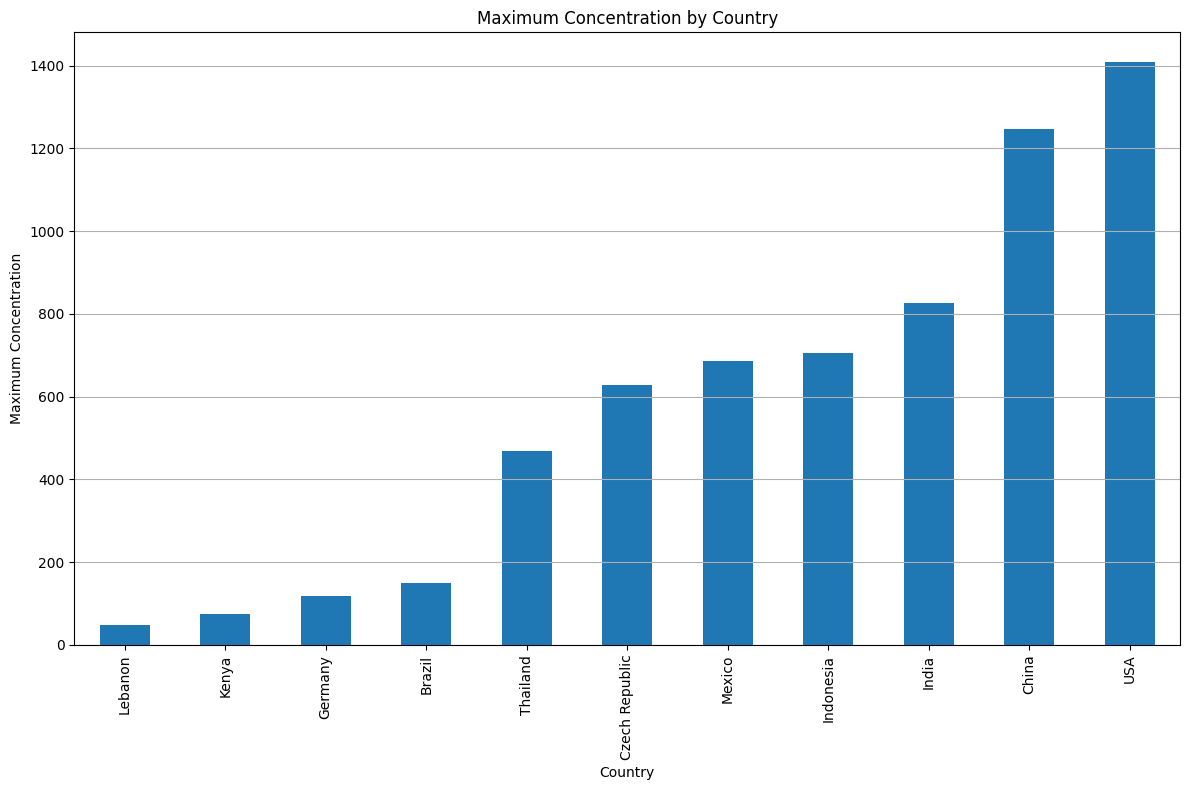

In [49]:
# Plot Maximum Concentration by Country bar graph
plt.figure(figsize=(12, 8))
max_concentration_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Maximum Concentration')
plt.title('Maximum Concentration by Country')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

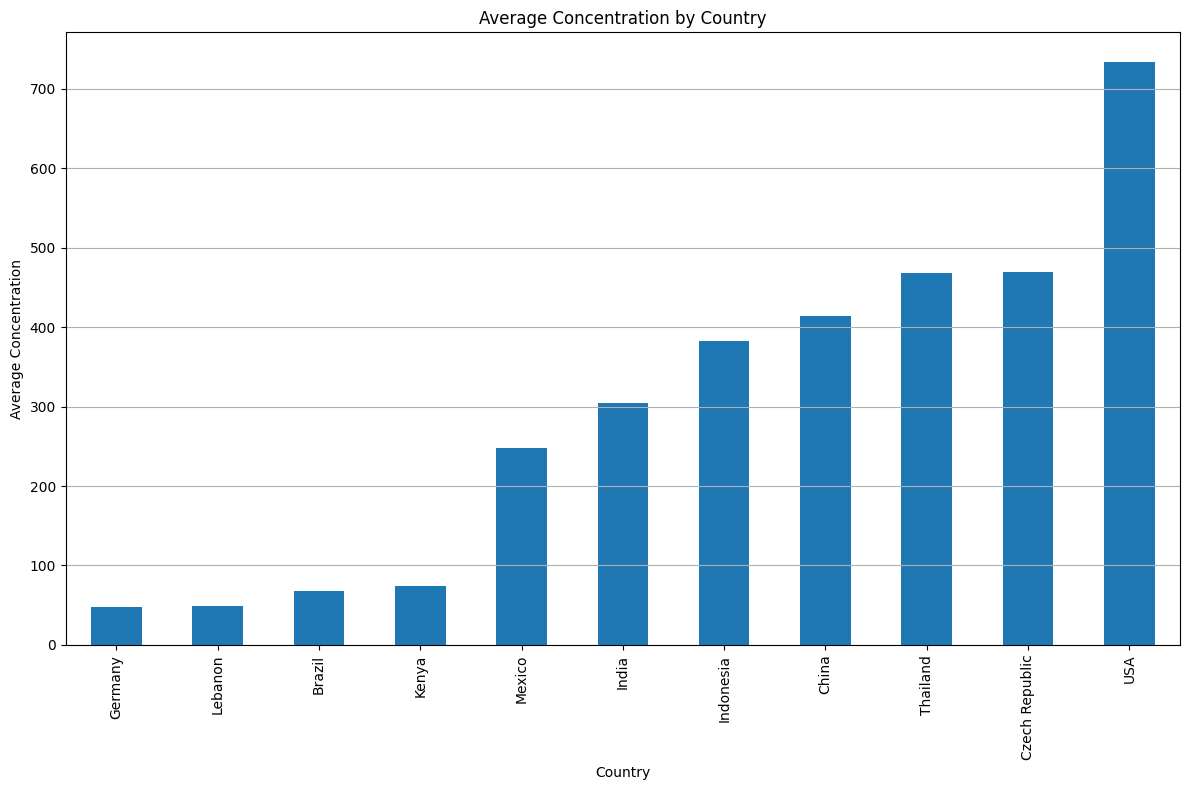

In [50]:
# Plot Average Concentration by Country bar graph
plt.figure(figsize=(12, 8))
avg_concentration_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Average Concentration')
plt.title('Average Concentration by Country')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Data Exploration (Material_PE)
After we decided to swap over to concentrations of Polyethylene (PE), we came across some interesting values when comparing the data. We noticed that the average concentrations of PE were higher in China, even though earlier we saw the total concentrations were higher in the United States. We also saw that the average concentrations of PE were higher in tap water compared to bottled water, which contradicted our personal predictions. Lastly, we compared the concentrations of Polyethylene against that of Polypropylene (PP) and saw that PP had higher concentrations on average, but decided to stick with PE for our models, since we didn't want to change our focus too much, and because we believed PE to be more harmful.

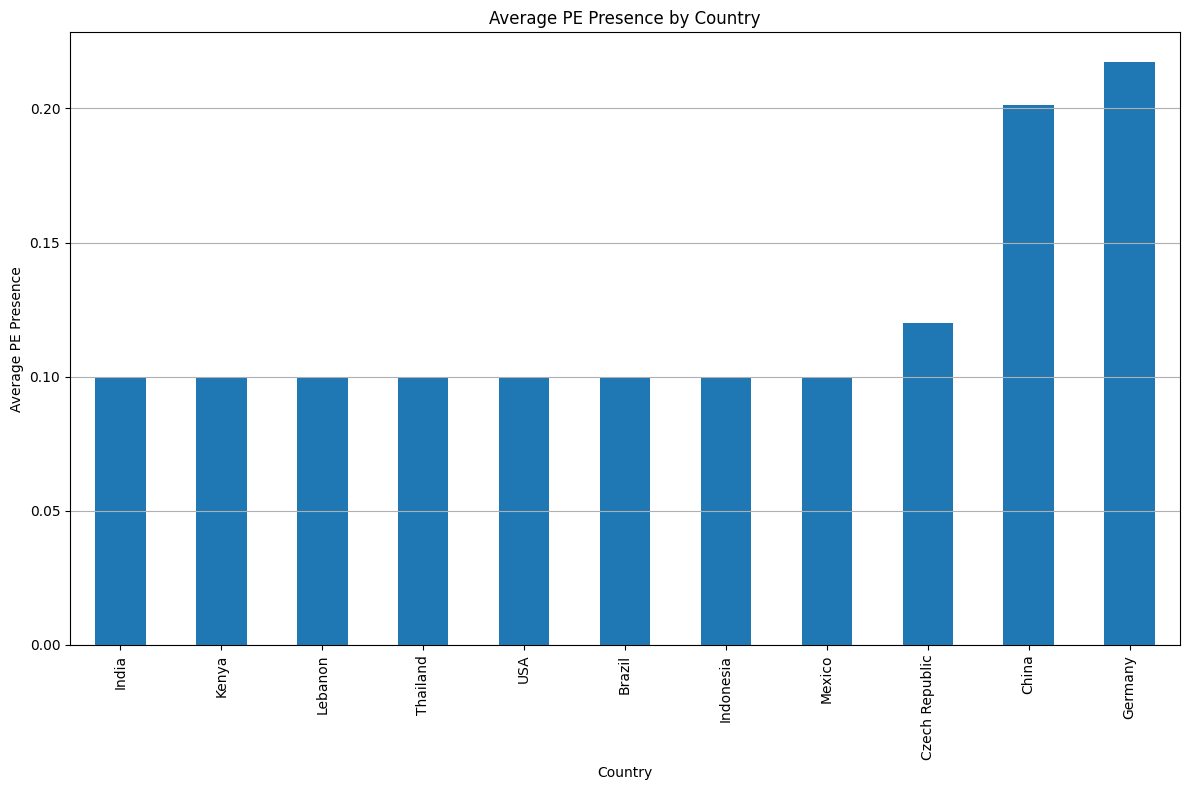

Countries
India             0.100000
Kenya             0.100000
Lebanon           0.100000
Thailand          0.100000
USA               0.100000
Brazil            0.100000
Indonesia         0.100000
Mexico            0.100000
Czech Republic    0.120000
China             0.201127
Germany           0.217500
Name: Material_PE, dtype: float64


In [51]:
# Of remaining rows left w/usuable data, find the avg PE portion of the water sample for each country
avg_pe_presence_by_country = df.groupby('Countries')['Material_PE'].mean()
avg_pe_presence_by_country = avg_pe_presence_by_country.sort_values(ascending=True)

# Plot the bar graph
plt.figure(figsize=(12, 8))
avg_pe_presence_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Average PE Presence')
plt.title('Average PE Presence by Country')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Displays the values in text for understanding
print(avg_pe_presence_by_country)

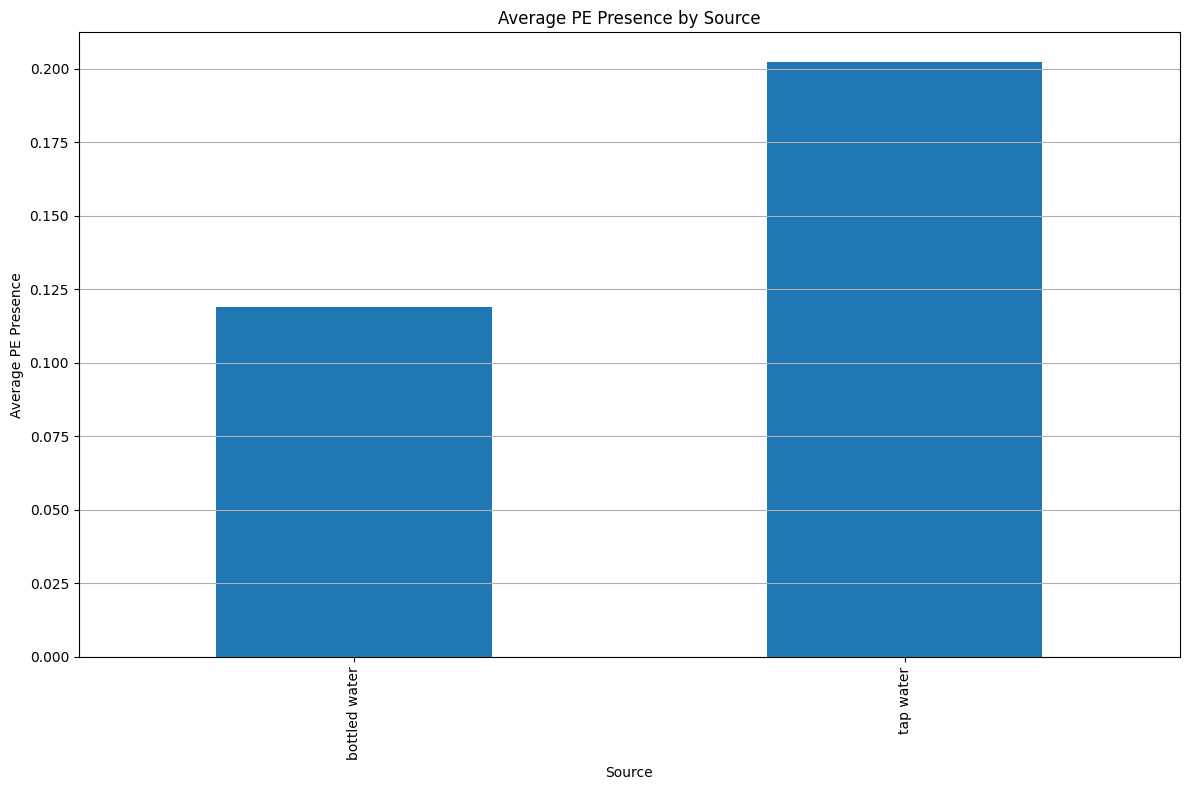

In [52]:
# Compute the average amount of PE by water source
avg_pe_presence_by_source = df.groupby('Source')['Material_PE'].mean()
avg_pe_presence_by_source = avg_pe_presence_by_source.sort_values(ascending=True)

# Plot the bar graph
plt.figure(figsize=(12, 8))
avg_pe_presence_by_source.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Average PE Presence')
plt.title('Average PE Presence by Source')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

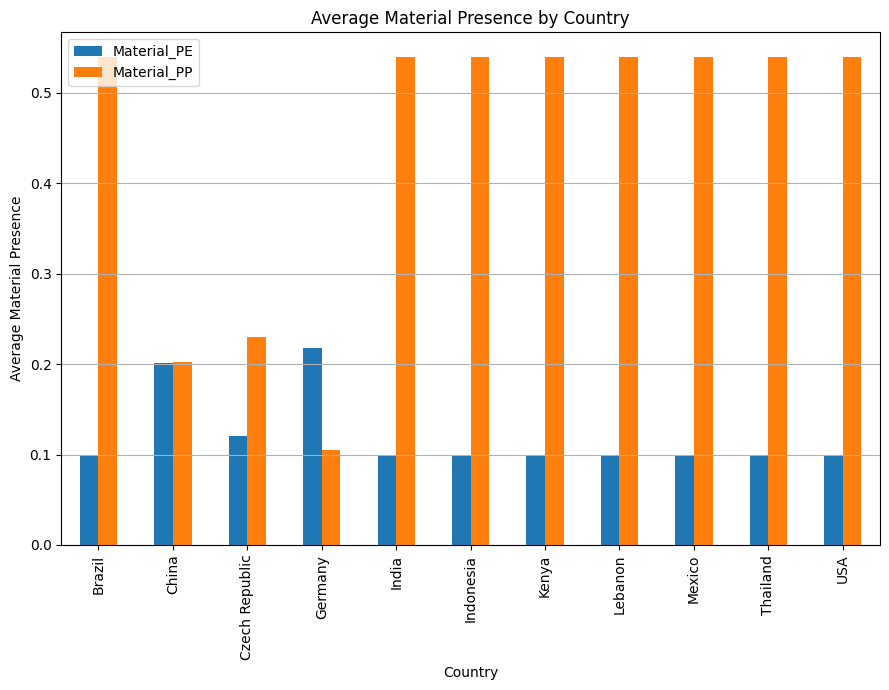

In [53]:
# Compute the average amount of PE and PP by country
avg_material_by_country = df.groupby('Countries')[['Material_PE', 'Material_PP']].mean()

plt.figure(figsize=(12, 8))
avg_material_by_country.plot(kind='bar')
plt.title('Average Material Presence by Country')
plt.xlabel('Country')
plt.ylabel('Average Material Presence')
plt.grid(axis='y')
plt.legend(['Material_PE', 'Material_PP'])
plt.tight_layout()
plt.show()

# Model 1 - Random Forest Regressor

> For our first model, we chose to try and make predictions on Material_PE (Polyethylene) and chose to use the Random Forest Regressor. While the RMSE was relatively low, the plotted data led us to believe that the Random Forest Regressor was unlikely to work for our predictions, even after changing around some of the training and fit variables and estimators.




In [54]:
# Select columns to keep
columns_to_keep = ['Countries', 'Material_PE']

# Subset the dataframe
df_subset = df[columns_to_keep]
print(df['Material_PE'].count())
print(df['Material_PE'].unique())
# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df_subset)

# Define target
target = 'Material_PE'

# Define predictors
predictors = df_encoded.drop(columns=[target]).columns
X = df_encoded[predictors].values
y = df_encoded[target].values

# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Use Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the Random Forest model
rf = RandomForestRegressor(n_estimators=32, random_state=0) # Not too sure about this. RMSE is pretty high,
rf.fit(X_train_poly, y_train)                               # playing with the n_estimators value doesn't change much.

# Predict
predict = rf.predict(X_test_poly)

# Evaluate
mse = ((predict - y_test)**2).mean()
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

80
[0.09  0.05  0.35  0.38  0.1   0.12  0.267 0.044]
Mean Squared Error: 0.017387526246365925
Root Mean Squared Error: 0.13186176946471606


# Model 2 - K Neighbors Regressor

> For our second model we chose to try the kNN regression model. Overall, the kNN model performance varied with different values of k, but none of the models achieved particularly good performance, as indicated by the relatively high RMSE values. Further experimentation with different algorithms or parameter tuning may be warranted to improve the model's predictive accuracy.




In [55]:
# Tried using kNN to see how everything would turn up, not very good.
# Define RMSE function
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())

# Define function to compute train and test RMSE
def get_train_test_rmse(regr, X_train, X_test, y_train, y_test):
    regr.fit(X_train, y_train)
    predict_train = regr.predict(X_train)
    predict_test = regr.predict(X_test)
    rmse_tr = rmse(predict_train, y_train)
    rmse_te = rmse(predict_test, y_test)
    return rmse_tr, rmse_te

# Define function to get the best k value
def get_best(ks, rmse):
    best_rmse = min(rmse)
    best_k = ks[rmse.index(best_rmse)]
    return best_k, best_rmse

# Select columns to keep
columns_to_keep = ['Countries', 'Material_PE']

# Subset the dataframe
df_subset = df[columns_to_keep]

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df_subset)

# Define target
target = 'Material_PE'

# Define predictors
predictors = df_encoded.drop(columns=[target]).columns
X = df_encoded[predictors].values
y = df_encoded[target].values

# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Set up KNN regressor
ks = [1, 3, 5, 7, 9, 11, 13, 15]
train_rmse = []
test_rmse = []
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    rmse_tr, rmse_te = get_train_test_rmse(knn, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)

    print(f"For k = {k}, Training RMSE: {rmse_tr}, Testing RMSE: {rmse_te}")


For k = 1, Training RMSE: 0.08509249169496182, Testing RMSE: 0.1547702598477283
For k = 3, Training RMSE: 0.08618599534524618, Testing RMSE: 0.1503435263851621
For k = 5, Training RMSE: 0.08358056848676867, Testing RMSE: 0.12311264489618172
For k = 7, Training RMSE: 0.0872050317676547, Testing RMSE: 0.1261230131886418
For k = 9, Training RMSE: 0.08635612990888086, Testing RMSE: 0.1279525214156623
For k = 11, Training RMSE: 0.09135301595570378, Testing RMSE: 0.1219798466509149
For k = 13, Training RMSE: 0.09228284578605943, Testing RMSE: 0.12406328712010399
For k = 15, Training RMSE: 0.09069583608159573, Testing RMSE: 0.12018265728095343


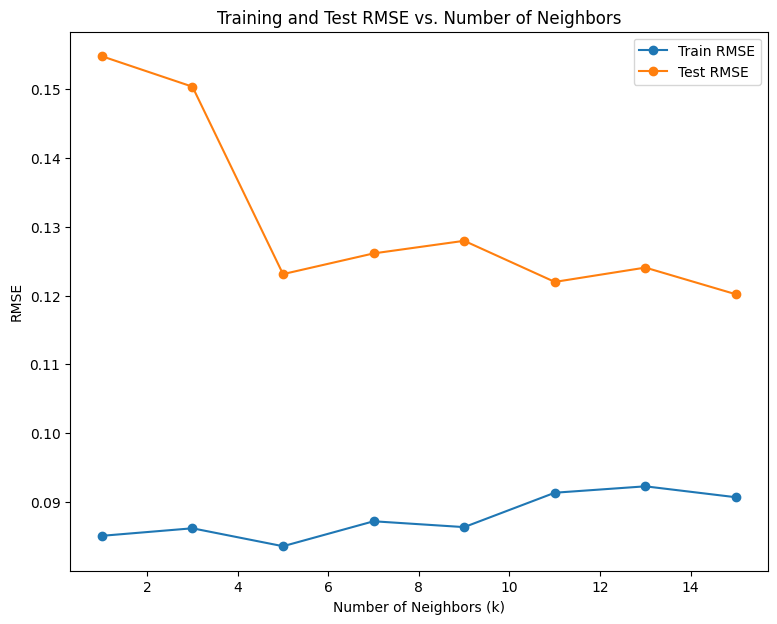

In [56]:
# Plot the training and test RMSE values
plt.plot(ks, train_rmse, marker = "o", label='Train RMSE')
plt.plot(ks, test_rmse, marker = "o", label='Test RMSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('Training and Test RMSE vs. Number of Neighbors')
plt.legend()
plt.show()

Best k = 15, Best test RMSE: 0.1202
0.014443871111111109
0.12018265728095343


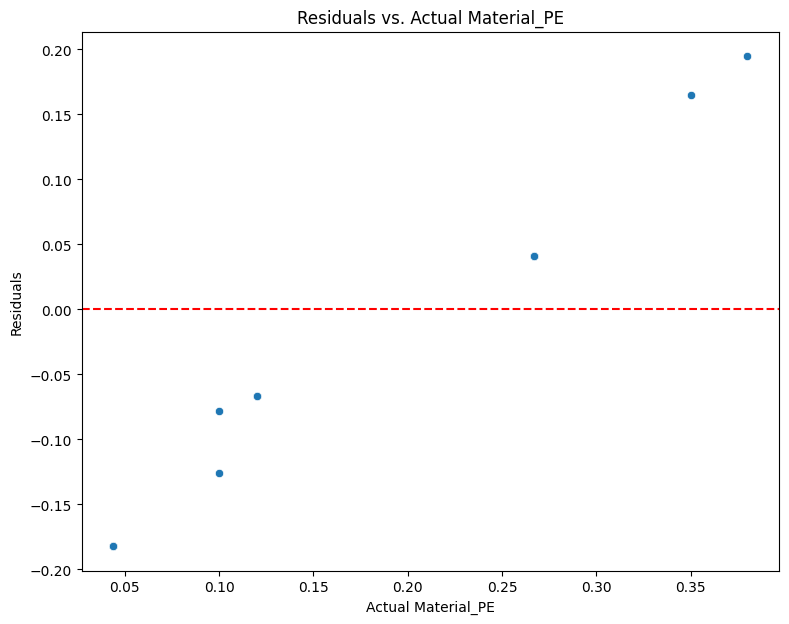

In [57]:
# Using kNN
# Get the best k value and its corresponding RMSE
best_k, best_rmse = get_best(ks, test_rmse)
print('Best k = {}, Best test RMSE: {:0.4f}'.format(best_k, best_rmse))

knn = KNeighborsRegressor(n_neighbors=best_k)
# Train the KNN model
knn.fit(X_train, y_train)
# Predict
predict = knn.predict(X_test)

# Evaluate
mse = ((predict - y_test)**2).mean()
print(mse)
rmse2 = np.sqrt(((predict - y_test)**2).mean())
print(rmse2)

# Calculate residuals
residuals = y_test - predict

# Plot residuals vs. actual values
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Material_PE')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Material_PE')
plt.show()

# Model 3 - Decision Tree Regressor



> For the last model we tried to do a Decision Tree Regression model. In this case, the relatively low MSE and RMSE values suggest that the decision tree model performed reasonably well in capturing the underlying patterns in the data and making predictions. However, the simplicity and small amount of data make these predictions less valuable.



In [58]:
# Decision Tree
# Select columns to keep
columns_to_keep = ['Countries', 'Material_PE']

# Subset the dataframe
df_subset = df[columns_to_keep]

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df_subset)

# Define target
target = 'Material_PE'

# Define predictors
predictors = df_encoded.drop(columns=[target]).columns
X = df_encoded[predictors].values
y = df_encoded[target].values

# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Decision Tree model
dt = DecisionTreeRegressor(criterion='friedman_mse',
                           splitter='best',
                           max_depth=2,
                           min_samples_split=2,
                           min_samples_leaf=4,
                           max_features='log2',
                           random_state=0)

# Fit the Decision Tree model
dt.fit(X_train, y_train)

# Predict
predict = dt.predict(X_test)

# Evaluate
mse = ((predict - y_test)**2).mean()
print(mse)
rmse = np.sqrt(((predict - y_test)**2).mean())
print(rmse)

0.012676718643707487
0.11259093499792729


# Results



> Each model was trained and tested using the same dataset, with their respective metrics assessed for accuracy.
The Random Forest model yielded a mean squared error (MSE) of 0.017 and a root mean squared error (RMSE) of 0.132.
For kNN Regression, varying values of k were explored, resulting in different training and testing RMSEs across different k values, but ultimately had too high of a MSE and RMSE to be used accurately.
Finally, the Decision Tree Regression model produced an MSE of 0.013.
Overall, these results tell us that the Decision Tree Regression model was the best fit for our dataset, but still was unable to provide a useful prediction for the amount of data we had to work with.




# Discussion



> In the end we were unable to provide any reliable predictions based on the values obtained from the dataset.
When first selecting the dataset it seemed very promising but later we discovered just how many actual samples we were able to use.
Many of the samples had many null values or values with mismatched data types.
This made it very difficult to use the majority of the data present at the beginning and after cleaning we only had around 60 samples, most of which fell under the same 7 or so concentration values, making predictions unlikely to be accurate.
There are still other models that we could try but at this point the dataset seems to be holding us back the most.




# Summary



> This project started out with the goal of reliably predicting the safety of water for consumption based on the amount of microplastics found in similar sources.
Once we got into the data we changed predictors to one with a more reliable set of values in the dataset.
After compiling and modifying our models we were unable to determine or predict the safety of water as the dataset had a few issues as previously mentioned.
This dataset is a work in progress and has been steadily updated since July 21 2022, but until the data becomes more reliable and regulated, there won’t be a way to accurately predict the safety of drinking water based on the microplastics found in similar sources.


